#### Description
This code creates a binary map from the cropland tif file as well as trims that map and the original cropland map to only arid regions

In [12]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

Convert to Binary Map

Binary cropland data saved successfully.


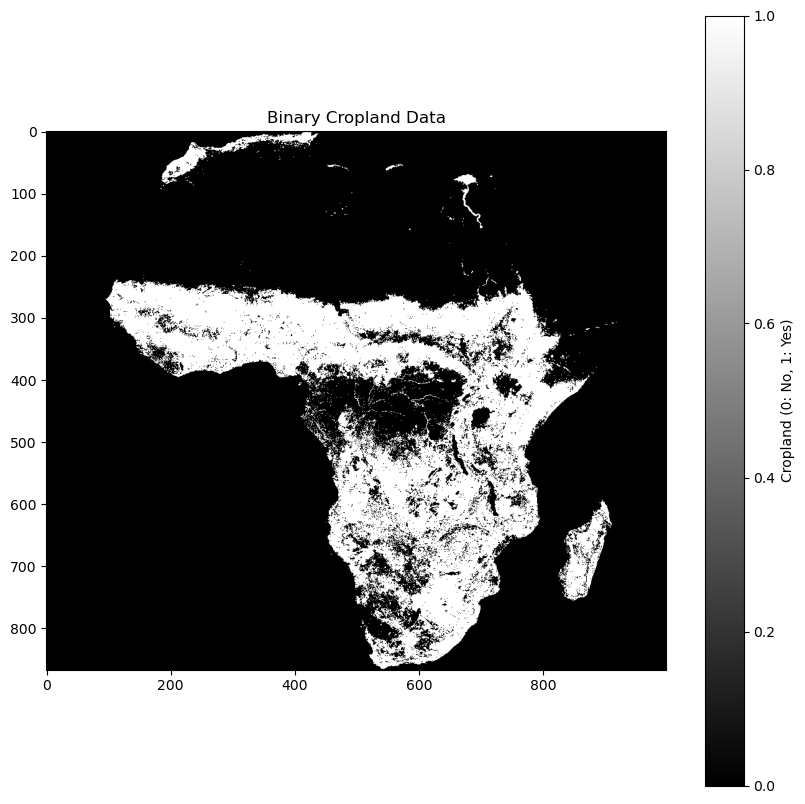

In [13]:
# Load the aridity shapefile (which includes country boundaries)
aridity_gdf = gpd.read_file(resolve_path(config['Africa_Arid_by_Country_shp_path']))
aridity_gdf.set_crs(epsg=4326, inplace=True)

# Load and process the cropland raster data
with rasterio.open(resolve_path(config['Africa_Cropland_tif_path'])) as src:
    cropland_data = src.read(1)
    
    # Convert to binary (0s and 1s) based on the threshold > 0
    cropland_binary = (cropland_data > 0).astype(np.uint8)

    # Define the metadata for the new binary TIFF file
    meta = src.meta
    meta.update(dtype=rasterio.uint8, nodata=None)

    # Save the binary data to a new TIFF file
    with rasterio.open(resolve_path(config['Binary_Cropland_tif_path']), 'w', **meta) as dst:
        dst.write(cropland_binary, 1)

print("Binary cropland data saved successfully.")

# Plot the binary cropland data
plt.figure(figsize=(10, 10))
plt.imshow(cropland_binary, cmap='gray')
plt.title('Binary Cropland Data')
plt.colorbar(label='Cropland (0: No, 1: Yes)')
plt.show()


Crop binary map using aridity data

Cropped binary cropland data saved successfully.


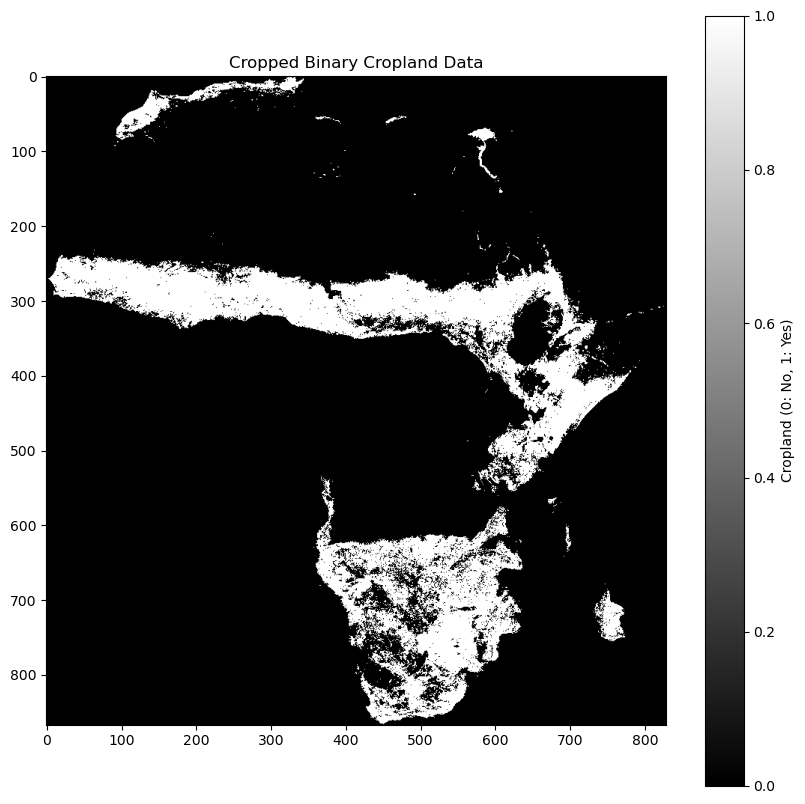

In [14]:

# Crop the binary cropland data using the aridity data
with rasterio.open(resolve_path(config['Binary_Cropland_tif_path'])) as src:
    # Use the geometries from the aridity data to mask (crop) the cropland raster
    cropped_cropland_binary, cropped_transform = mask(
        src, 
        aridity_gdf.geometry, 
        crop=True
    )
    
    # The cropped_cropland_binary might have an unnecessary band dimension, so ensure it's a 2D array
    cropped_cropland_binary = np.squeeze(cropped_cropland_binary, axis=0)

    # Update metadata with new transform and size after cropping
    cropped_meta = meta.copy()
    cropped_meta.update({
        "height": cropped_cropland_binary.shape[0],
        "width": cropped_cropland_binary.shape[1],
        "transform": cropped_transform
    })

    # Save the cropped binary cropland data to the specified path
    with rasterio.open(resolve_path(config['Binary_Arid_Cropland_tif_path']), 'w', **cropped_meta) as dst:
        dst.write(cropped_cropland_binary, 1)

print("Cropped binary cropland data saved successfully.")

# Plot the cropped binary cropland data
plt.figure(figsize=(10, 10))
plt.imshow(cropped_cropland_binary, cmap='gray')
plt.title('Cropped Binary Cropland Data')
plt.colorbar(label='Cropland (0: No, 1: Yes)')
plt.show()

Crop the original cropland data using aridity data

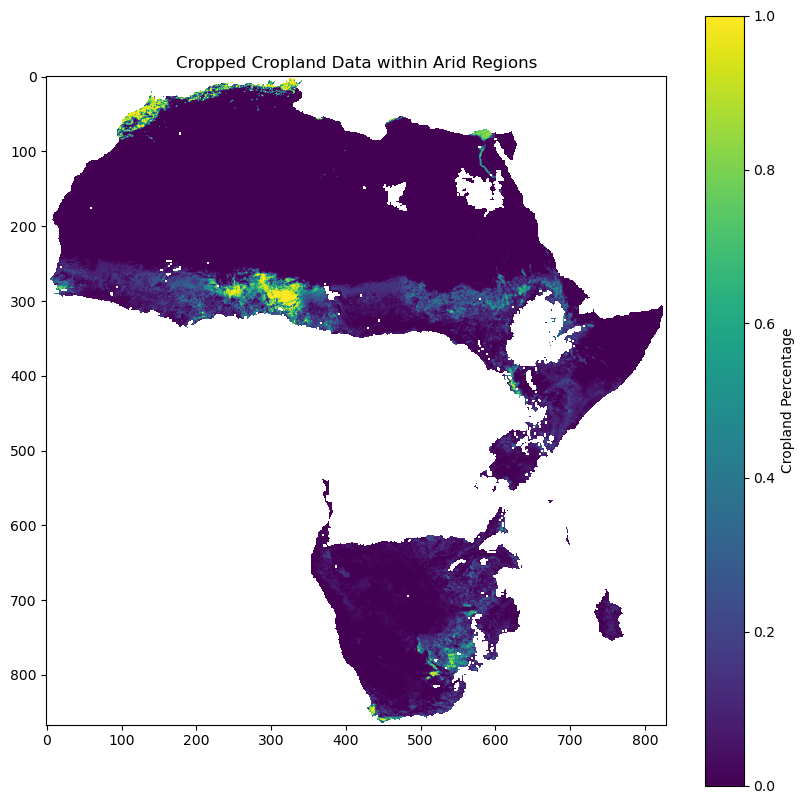

In [16]:

# Load the arid regions shapefile
arid_africa = gpd.read_file(resolve_path(config['Africa_All_shp_path']))

# Define the path to the raw cropland TIFF file
raw_cropland_tif_path = resolve_path(config['Africa_Cropland_tif_path'])

with rasterio.open(raw_cropland_tif_path) as raw_cropland_data:
    # Define a no-data value
    nodata_value = np.nan
    
    # Clip the cropland data to the extent of arid regions
    raw_cropland_clipped, raw_cropland_transform = mask(
        raw_cropland_data, arid_africa.geometry, crop=True, nodata=nodata_value, filled=True
    )
    
    # Update the metadata to include the no-data value
    raw_cropland_meta = raw_cropland_data.meta.copy()
    raw_cropland_meta.update({
        'height': raw_cropland_clipped.shape[1],
        'width': raw_cropland_clipped.shape[2],
        'transform': raw_cropland_transform,
        'nodata': nodata_value
    })

# Save the cropped cropland data with the no-data value
raw_cropland_clipped_path = resolve_path(config['Arid_Cropland_tif_path'])
with rasterio.open(raw_cropland_clipped_path, 'w', **raw_cropland_meta) as dst:
    dst.write(raw_cropland_clipped)

# Visualization to verify the result
import matplotlib.pyplot as plt

with rasterio.open(raw_cropland_clipped_path) as cropped_data:
    cropped_image = cropped_data.read(1)
    plt.figure(figsize=(10, 10))
    plt.imshow(cropped_image, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label='Cropland Percentage')
    plt.title('Cropped Cropland Data within Arid Regions')
    plt.show()
